# Linking to Google Drive

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/skillsEval/skillsEval

/content/drive/My Drive/skillsEval/skillsEval


# Importing Important Libraries

In [ ]:
!pip install simpleitk

     |████████████████████████████████| 48.4 MB 22 kB/s 


In [ ]:
import SimpleITK as sitk
#from downloaddata import fetch_data as fdata
%matplotlib nbagg

import numpy as np
import os


In [ ]:
run gui.py

In [ ]:
run registration_gui.py

**Utility functions** 

A number of utility callback functions for image display and for plotting the similarity metric during registration.



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

# Reading the Images

I first read the images and then visualised 

In [ ]:
fixed_image =  sitk.ReadImage(("ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(("mr.mha"), sitk.sitkFloat32) 

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=14, description='fixed_image_z', max=28), IntSlider(value=12, descriptio…

# Initialization

I am applying CenteredTransformInitializer Filter of both the types i.e GEOMETRY and MOMENTS

In [ ]:
initial_transform_1 = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled_1 = sitk.Resample(moving_image, fixed_image, initial_transform_1, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

#interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));


In [ ]:
initial_transform_2 = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled_2 = sitk.Resample(moving_image, fixed_image, initial_transform_2, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Registration

For Metric MattesMutualInformation  and GEOMETRY Initialiser 

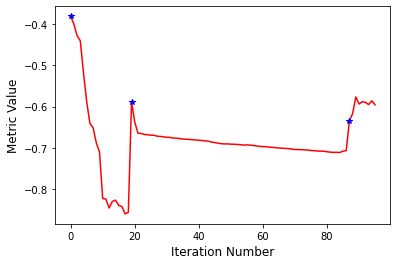

In [ ]:
registration_method_1 = sitk.ImageRegistrationMethod()

# Similarity metric settings, mutual information (Mattes MI)
registration_method_1.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method_1.SetMetricSamplingStrategy(registration_method_1.RANDOM)
registration_method_1.SetMetricSamplingPercentage(0.01)

registration_method_1.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method_1.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method_1.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method_1.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method_1.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method_1.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method_1.SetInitialTransform(initial_transform_1, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method_1.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method_1.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method_1.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method_1.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method_1))

final_transform_1 = registration_method_1.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

For Metric MattesMutualInformation and MOMENTS Initialiser 

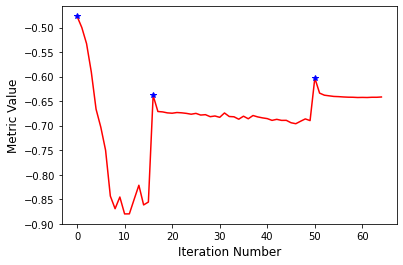

In [ ]:
registration_method_2 = sitk.ImageRegistrationMethod()

# Similarity metric settings, mutual information (Mattes MI)
registration_method_2.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method_2.SetMetricSamplingStrategy(registration_method_2.RANDOM)
registration_method_2.SetMetricSamplingPercentage(0.01)

registration_method_2.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method_2.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method_2.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method_2.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method_2.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method_2.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method_2.SetInitialTransform(initial_transform_2, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method_2.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method_2.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method_2.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method_2.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method_2))

final_transform_2 = registration_method_2.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

# Post Registration Analysis

**Metric Value of different Transforms**

In [ ]:
print('Final metric value: {0}'.format(registration_method_1.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method_1.GetOptimizerStopConditionDescription()))

Final metric value: -0.5859611141739798
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [ ]:
print('Final metric value: {0}'.format(registration_method_2.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method_2.GetOptimizerStopConditionDescription()))

Final metric value: -0.6415937918940307
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 15.


In [ ]:
moving_resampled_1 = sitk.Resample(moving_image, fixed_image, final_transform_1, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled_1));

interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

In [ ]:
moving_resampled_2 = sitk.Resample(moving_image, fixed_image, final_transform_2, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled_2));

interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

In [ ]:
OUTPUT_DIR = 'Output'
print(final_transform_1)

itk::simple::Transform
 CompositeTransform (0x5619fb997a20)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 373963
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x5619fb996b20)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 373804
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.997035 0.0768954 -0.00285967 
       -0.0769172 0.997001 -0.00851634 
       0.00219622 0.00871105 0.99996 
     Offset: [8.33199, -19.7377, -24.4686]
     Center: [166.994, 166.994, 56]
     Translation: [20.5178, -33.5601, -22.6494]
     Inverse: 
       0.997035 -0.0769172 0.00219622 
       0.0768954 0.997001 0.00871105 
       -0.00285967 -0.00851634 0.99996 
     Singular: 0
     Euler's angles: AngleX=0.00871116 AngleY=-0.00219631 AngleZ=-0.0769743
     m_ComputeZYX = 0
   End of MultiT

In [ ]:
OUTPUT_DIR = 'Output'
print(final_transform_2)

itk::simple::Transform
 CompositeTransform (0x5619fb996580)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 555163
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x5619fb997840)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 555004
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.997521 0.0703436 0.00171356 
       -0.0703294 0.997497 -0.00730348 
       -0.00222303 0.00716487 0.999972 
     Offset: [6.97271, -20.6082, -22.0993]
     Center: [170.222, 160.659, 57.3959]
     Translation: [17.9505, -33.4011, -21.3282]
     Inverse: 
       0.997521 -0.0703294 -0.00222303 
       0.0703436 0.997497 0.00716487 
       0.00171356 -0.00730348 0.999972 
     Singular: 0
     Euler's angles: AngleX=0.00716493 AngleY=0.00222309 AngleZ=-0.0704036
     m_ComputeZYX = 0
   End of 

# References

https://github.com/SimpleITK/TUTORIAL/blob/master/05_basic_registration.ipynb

http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

https://www.youtube.com/playlist?list=PLJrE5DPJLkqV68MXHXPGX64loB6ul2Y0H